In [ ]:
!pip install transformers
!pip install sentence-transformers

In [2]:
import warnings
warnings.filterwarnings('ignore')

# basics
import numpy as np
import matplotlib.pyplot as plt

# ml
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# dl
import torch
from sentence_transformers import CrossEncoder
from transformers import BertTokenizer, BertModel

# nlp
import gensim.downloader as api

In [3]:
# load in glov model and examine words&dimensions
word_vector = api.load('glove-wiki-gigaword-100')

[==================================================] 100.0% 128.1/128.1MB downloaded


In [4]:
word_vector['king'].shape

(100,)

In [6]:
word_vector['king'][:20]

array([-0.32307 , -0.87616 ,  0.21977 ,  0.25268 ,  0.22976 ,  0.7388  ,
       -0.37954 , -0.35307 , -0.84369 , -1.1113  , -0.30266 ,  0.33178 ,
       -0.25113 ,  0.30448 , -0.077491, -0.89815 ,  0.092496, -1.1407  ,
       -0.58324 ,  0.66869 ], dtype=float32)

In [7]:
word_vector.most_similar('king')

[('prince', 0.7682328820228577),
 ('queen', 0.7507690787315369),
 ('son', 0.7020888328552246),
 ('brother', 0.6985775232315063),
 ('monarch', 0.6977890729904175),
 ('throne', 0.6919989585876465),
 ('kingdom', 0.6811409592628479),
 ('father', 0.6802029013633728),
 ('emperor', 0.6712858080863953),
 ('ii', 0.6676074266433716)]

### Let's visualize the word vectors

In [8]:
# Words to visualize
words = ["king", "princess", "monarch", "throne", "crown",
         "mountain", "ocean", "tv", "rainbow", "cloud", "queen"]

# Get word vectors
vectors = []
for i in range(len(words)):
  vectors.append(np.array(word_vector[words[i]]))

In [9]:
print(f'number of words: {len(vectors)}\ndimension of each word: {len(vectors[0])}')

number of words: 11
dimension of each word: 100


In [10]:
# Reduce dimensions using PCA
pca = PCA(n_components=2)
vectors_pca = pca.fit_transform(vectors)

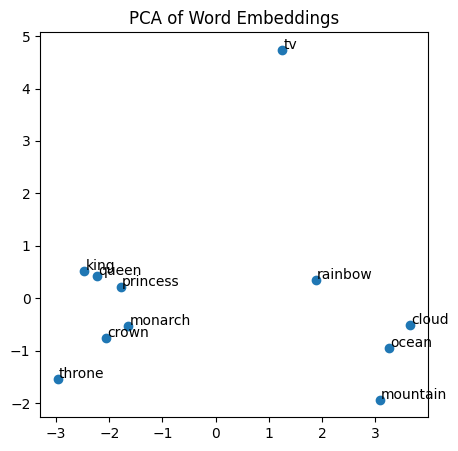

In [11]:
# Plotting
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
axes.scatter(vectors_pca[:, 0], vectors_pca[:, 1])
for i, word in enumerate(words):
    axes.annotate(word, (vectors_pca[i, 0]+.02, vectors_pca[i, 1]+.02))
axes.set_title('PCA of Word Embeddings')
plt.show()

### Word2Vec algebraic computation of vectors

In [15]:
result = word_vector.most_similar(positive=['yoda', 'evil'],
                                   negative=['good'], topn=1)

# Output the result
print(f"""
    The word closest to 'yoda' - 'good' + 'evil' is: '{result[0][0]}'
    with a similarity score of {result[0][1]}""")


    The word closest to 'yoda' - 'good' + 'evil' is: 'darth' 
    with a similarity score of 0.6636424660682678


In [16]:
result

[('darth', 0.6636424660682678)]

In [ ]:
tokenizer = BertTokenizer.from_pretrained('google-bert/bert-base-uncased')
model = BertModel.from_pretrained('google-bert/bert-base-uncased')

In [23]:
# generate a text and obtain the tokenized values

text = "destined for greatness."

encoded_input = tokenizer(text, return_tensors='pt')

# 101 & 102 special tokens CLS & SEP
# token type for each token in the sequence. Since this is a single sentence (not a pair of sentences), all values are 0.
# attention mask This tensor indicates which tokens should be attended to by the model (1)
# and which should be ignored (0). In this case, all tokens are attended to because the entire input sequence is meaningful.
encoded_input

{'input_ids': tensor([[  101, 16036,  2005,  2307,  2791,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

In [37]:
# let's check the vocabulary
vocab = tokenizer.get_vocab()
for key, value in vocab.items():
  if value in encoded_input['input_ids'][0]:
    print(f'{key}: {value}')

[CLS]: 101
[SEP]: 102
.: 1012
for: 2005
great: 2307
##ness: 2791
destined: 16036


In [62]:
tokenizer.get_vocab()

101

In [38]:
# now lets generate embeddings for the tokens
output = model(**encoded_input)

In [55]:
output['last_hidden_state'][0][1]

torch.Size([768])

In [63]:
def get_bert_embeddings(sentence, word):
    inputs = tokenizer(sentence, return_tensors='pt')
    outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    word_tokens = tokenizer.tokenize(sentence)
    word_index = word_tokens.index(word)
    word_embedding = last_hidden_states[0, word_index + 1, :]  # +1 to account for [CLS] token
    return word_embedding

In [65]:
sentence1 = "The bat flew out of the cave at night."
sentence2 = "He swung the bat and hit a home run."

word = "bat"

bert_embedding1 = get_bert_embeddings(sentence1, word).detach().numpy()
bert_embedding2 = get_bert_embeddings(sentence2, word).detach().numpy()
word_embedding = word_vector[word]

In [66]:
print("BERT Embedding for 'bat' in sentence 1:", bert_embedding1[:5])
print("BERT Embedding for 'bat' in sentence 2:", bert_embedding2[:5])
print("GloVe Embedding for 'bat':", word_embedding[:5])

bert_similarity = cosine_similarity([bert_embedding1], [bert_embedding2])[0][0]
word_embedding_similarity = cosine_similarity([word_embedding], [word_embedding])[0][0]

print()
print(f"Cosine Similarity between BERT embeddings in different contexts: {bert_similarity}")
print(f"Cosine Similarity between GloVe embeddings: {word_embedding_similarity}")


BERT Embedding for 'bat' in sentence 1: [ 0.4131613  -0.12908208 -0.44865727 -0.40492675 -0.15305734]
BERT Embedding for 'bat' in sentence 2: [ 0.64066994 -0.31121498 -0.44089845 -0.16551109 -0.2005611 ]
GloVe Embedding for 'bat': [-0.47601  0.81705  0.11151 -0.22687 -0.80672]

Cosine Similarity between BERT embeddings in different contexts: 0.459957480430603
Cosine Similarity between GloVe embeddings: 1.0


### Cross Encoder

In [ ]:
from sentence_transformers import CrossEncoder
model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2', max_length=512,
                     default_activation_function=torch.nn.Sigmoid())

In [68]:
question = "Where is the capital of France?"
# Define sentences to compare
answers = [
    "Paris is the capital of France.",
    "Berlin is the capital of Germany.",
    "Madrid is the capital of Spain."
]

In [69]:
scores = model.predict([(question, answers[0]), (question, answers[1]),
                        (question, answers[2])])
print(scores)
most_relevant_idx = torch.argmax(torch.tensor(scores)).item()
print(f"The most relevant passage is: {answers[most_relevant_idx]}")

[0.99965715 0.0528962  0.04520684]
The most relevant passage is: Paris is the capital of France.
